In [1]:
# Some preliminary imports
%matplotlib inline

import numpy as np
import sklearn.datasets as data
import sklearn.metrics.pairwise as pairwise
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns

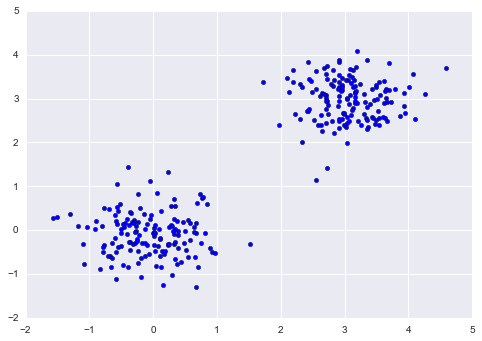

In [2]:
# Let's generate some toy data.
X, y = data.make_blobs(n_samples = 300, centers = np.array([[0, 0], [3, 3]]), cluster_std = 0.5, random_state = 12, shuffle = False)
plt.scatter(X[:, 0], X[:, 1])

Two extremely well-separated Gaussian clusters. This will be easy--really not even requiring spectral analysis--but it's fine for demo purposes.

### Let's explore

First step in any data science project: get a feel for the data. Fergus SSL relies quite on a big on the dimensions of the data being separable, so let's plot the histograms of each individual dimension.

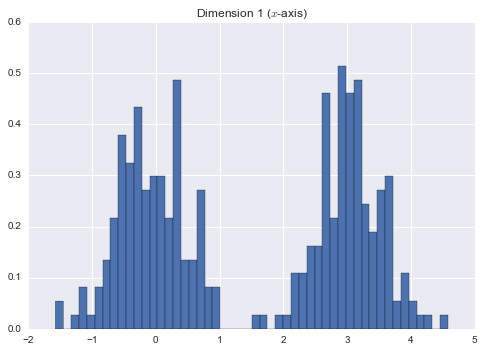

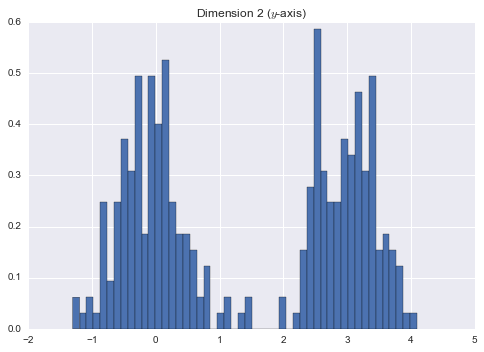

In [3]:
# We'll make the number of bins, B
B = 50
plt.figure(0)
plt.hist(X[:, 0], bins = B, normed = True)
plt.title("Dimension 1 ($x$-axis)")
plt.figure(1)
plt.hist(X[:, 1], bins = B, normed = True)
plt.title("Dimension 2 ($y$-axis)")

You see the data are easily separable along both the $x$ and $y$ axes. Put another way--if someone gives you an $x$ value of a data point and asks you what cluster the point comes from, it's easy to make that assessment. Same with just providing the $y$ value of a data point--you could easily predict what cluster it comes from.

Now let's make things a little harder.

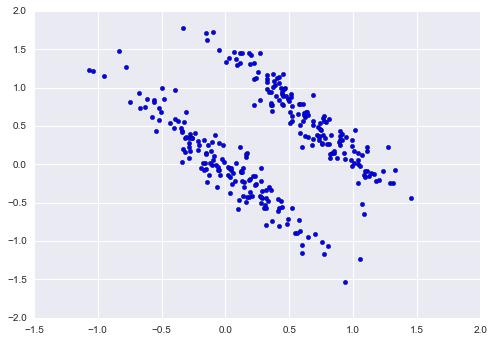

In [4]:
rng = np.random.RandomState(74)
t = rng.normal(size = (2, 2))
Xr = X @ t
plt.scatter(Xr[:, 0], Xr[:, 1])

We've effectively rotated the data about 45 degrees. If we now plot the 1D histograms for the $x$ and $y$ axes again...

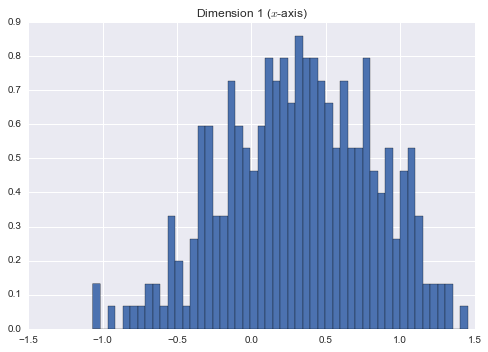

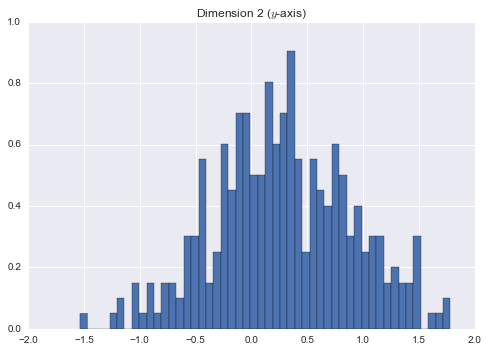

In [5]:
plt.figure(0)
plt.hist(Xr[:, 0], bins = B, normed = True)
plt.title("Dimension 1 ($x$-axis)")
plt.figure(1)
plt.hist(Xr[:, 1], bins = B, normed = True)
plt.title("Dimension 2 ($y$-axis)")

Good luck telling me where the clusters are! Now the dimensions are highly correlated. This is why, if this was the original data we were given, we need to perform a rotation on the data--decorrelate the axes so they become separable in one dimension (i.e. histograms).

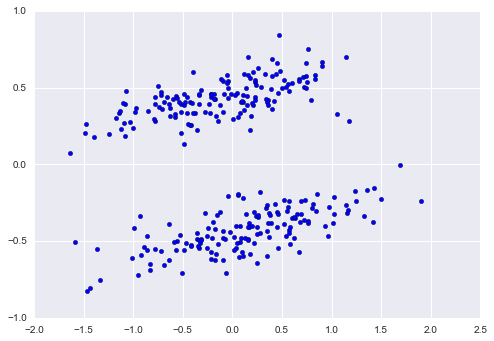

In [6]:
from sklearn.decomposition import RandomizedPCA

pca = RandomizedPCA(n_components = 2, random_state = 12)
Xt = pca.fit_transform(Xr)
plt.scatter(Xt[:, 0], Xt[:, 1])

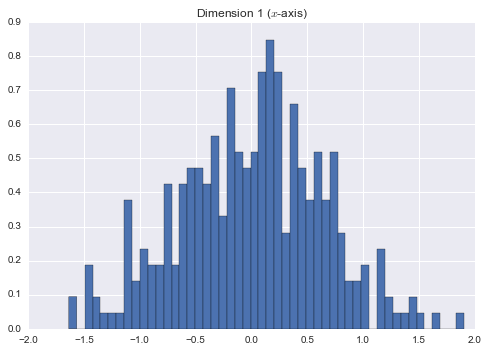

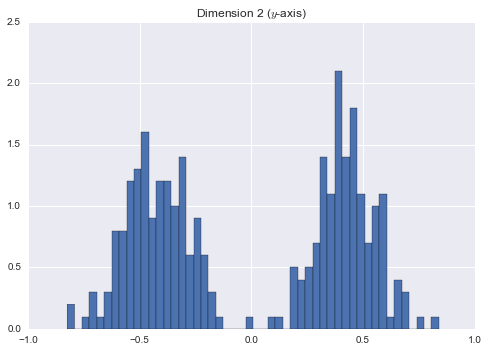

In [7]:
plt.figure(0)
plt.hist(Xt[:, 0], bins = B, normed = True)
plt.title("Dimension 1 ($x$-axis)")
plt.figure(1)
plt.hist(Xt[:, 1], bins = B, normed = True)
plt.title("Dimension 2 ($y$-axis)")

The $x$ axis is still a lost cause, but now the $y$ axis has become separable again!

### Fergus algorithm

Now let's start looking into what's required to do the semi-supervised learning according to Fergus *et al*.

In [8]:
# First, define the method that, given a 1D histogram of the data, will return the 
# solution to the generalized eigenvalue problem as defined in Eq. 2 of the Fergus paper.
import scipy.linalg as sla
def solve(hist):
    """
    hist : 1D histogram
    """
    W = pairwise.rbf_kernel(hist.reshape(-1, 1))
    P = np.diag(hist)
    PW = P @ W  #  matrix-matrix multiplication in Python 3
    PWP = PW @ P
    Ds = np.diag(PWP.sum(axis = 0))  # sum along the COLUMNS of PWP
    Dh = np.diag(PW.sum(axis = 0))  # sum along the COLUMNS of PW
    
    # Solve the generalized eigenvalue problem for symmetric matrices (this is, after all, a laplacian).
    L = Ds - PWP
    b = P @ Dh
    v, U = sla.eigh(L, b = b)
    return [v, U]

# Second, we'll create the 1D histograms for each dimension.
h1, e1 = np.histogram(Xt[:, 0], bins = B)
h2, e2 = np.histogram(Xt[:, 1], bins = B)
# Sidestep: add a small amount to each histogram bin, then renormalize to a density.
h1 = np.array(h1, dtype = np.float) + 0.01
h1 /= h1.sum()
h2 = np.array(h2, dtype = np.float) + 0.01
h2 /= h2.sum()

# Finally, we'll invoke the solver we wrote.
v1, U1 = solve(h1)
v2, U2 = solve(h2)

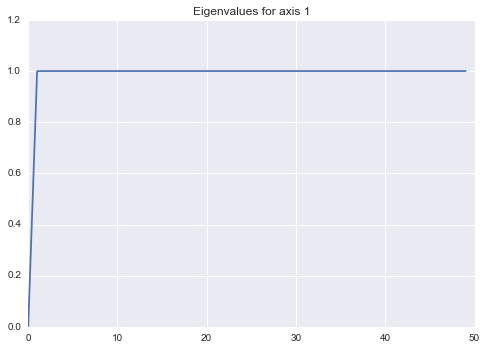

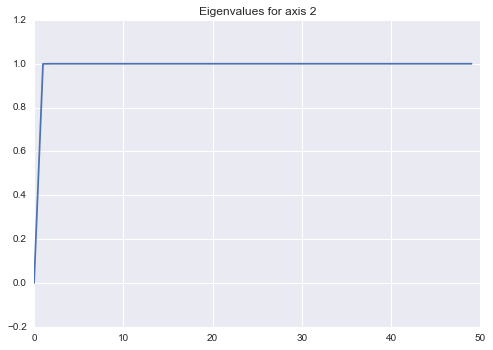

In [9]:
# How do the eigenvalues and eigenfunctions look?
plt.figure(0)
plt.title("Eigenvalues for axis 1")
plt.plot(v1)
plt.figure(1)
plt.title("Eigenvalues for axis 2")
plt.plot(v2)

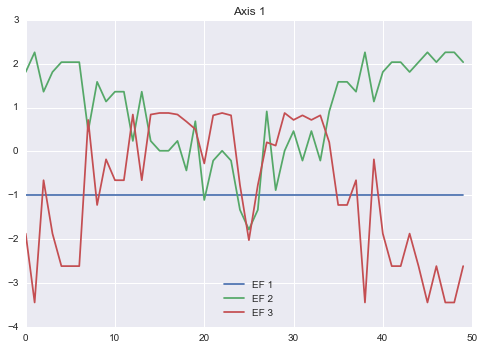

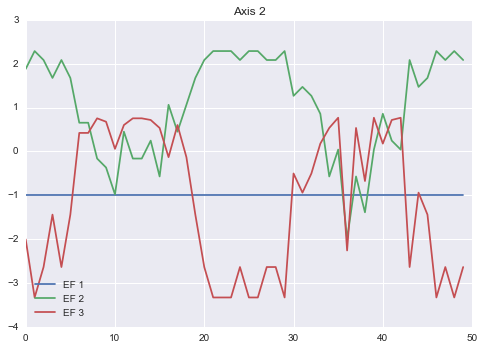

In [10]:
plt.figure(0)
plt.title("Axis 1")
plt.plot(U1[:, 0], label = "EF 1")
plt.plot(U1[:, 1], label = "EF 2")
plt.plot(U1[:, 2], label = "EF 3")
plt.legend(loc = 0)
plt.figure(1)
plt.title("Axis 2")
plt.plot(U2[:, 0], label = "EF 1")
plt.plot(U2[:, 1], label = "EF 2")
plt.plot(U2[:, 2], label = "EF 3")
plt.legend(loc = 0)

We can see things happening with the eigenfunctions--and, clearly, the eigenfunctions associated with the smallest eigenvalues are useless, but we knew this from looking at the examples in the Fergus paper itself--but let's continue on to get a feel for things in the interpolation process.

For simplicity, we'll just use the eigenfunctions associated with the 2nd axis ($y$ axis, in this particular case, but in $n$ dimensions this could be any axis).

In [11]:
# Assign the eigenfunctions
k = 2
EF = np.zeros(shape = (U2.shape[1], k))
EV = np.zeros(k)

EF[:, 0] = U1[:, 1]
EV[0] = v1[1]
EF[:, 1] = U2[:, 1]
EV[1] = v2[1]

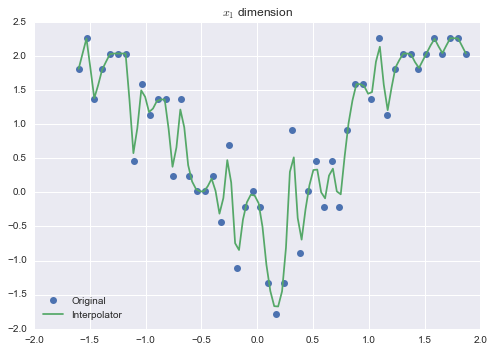

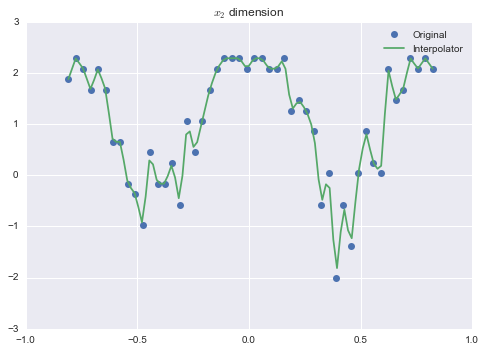

In [12]:
# Create the x-axis from the histogram edges.
x1 = np.array([e1[i:i + 2].mean() for i in range(e1.shape[0] - 1)])  # Finds the midpoints of the histogram bins.
x2 = np.array([e2[i:i + 2].mean() for i in range(e2.shape[0] - 1)])

# Now, use the eigenfunctions (y-axis) to create the interpolators.
f1 = interp1d(x1, EF[:, 0])
f2 = interp1d(x2, EF[:, 1])

# What do they look like?
x = np.linspace(x1.min(), x1.max(), 100)
plt.figure(0)
plt.title("$x_1$ dimension")
plt.plot(x1, EF[:, 0], 'o', label = 'Original')
plt.plot(x, f1(x), '-', label = 'Interpolator')
plt.legend(loc = 0)

y = np.linspace(x2.min(), x2.max(), 100)
plt.figure(1)
plt.title("$x_2$ dimension")
plt.plot(x2, EF[:, 1], 'o', label = 'Original')
plt.plot(y, f2(y), '-', label = 'Interpolator')
plt.legend(loc = 0)

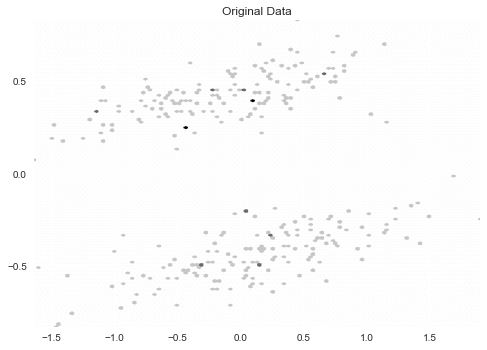

In [13]:
# We now have our eigenfunctions, at least in 1D. Let's see if we can reconstruct that heatmap from Fig 1.

plt.title("Original Data")
_ = plt.hexbin(Xt[:, 0], Xt[:, 1])

(-0.5, 99.5, 99.5, -0.5)

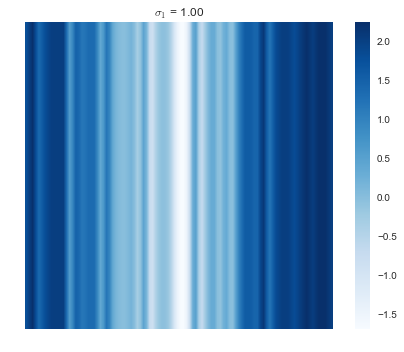

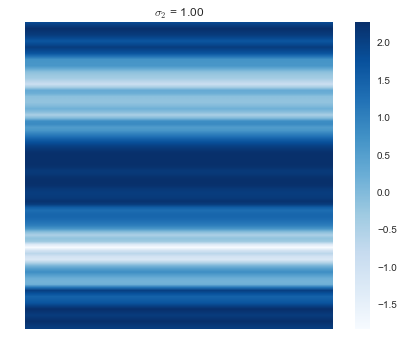

In [14]:
# Evaluate the eigenfunctions on each dimension.
fx = f1(x)
fy = f2(y)
fx_stack = np.vstack([fx for i in range(x.shape[0])])
fy_stack = np.hstack([fy.reshape(-1, 1) for i in range(y.shape[0])])

# Plot the heatmaps along the grid.
plt.figure(0)
plt.title("$\sigma_1$ = {:.2f}".format(EV[0]))
plt.imshow(fx_stack, cmap = 'Blues')
plt.colorbar()
plt.axis('off')
plt.figure(1)
plt.title("$\sigma_2$ = {:.2f}".format(EV[1]))
plt.imshow(fy_stack, cmap = 'Blues')
plt.colorbar()
plt.axis('off')